In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

### DL model results

In [17]:
key = '1d_precip_location_final1'
rname = 'results/classifier_outcomes_%s.csv' % key
outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)
outcomes = outcomes[3932:]
outcomes.shape

(1361, 117)

In [18]:
# create confusion matrix for outcome matrix at all quantiles
# create ROC matrix for outcome as well - points
outcomes_ana = outcomes.copy() # here outcomes is for test period
for col in outcomes_ana.columns[1:]:
    if outcomes_ana[col].dtypes == 'float64':
        outcomes_ana[col] = (outcomes_ana[col]> 0.5)

leads = [d for d in range(14)]
#quantiles = [0.50, 0.75, 0.80, 0.85, 0.9, 0.95]
quantiles = [0.50, 0.75, 0.9, 0.95]
points = pd.DataFrame(index=leads)
con_outcomes_ana = pd.DataFrame(outcomes_ana['ERA5']) #'ERA5'
models=['CNN','MLP']
for m in models:
    for q in quantiles:
        points['%s_%0.2f_TPR' % (m, q)] = leads
        points['%s_%0.2f_FPR' % (m, q)] = leads
        for l in leads:
            label = outcomes_ana['ERA5_%0.2f' % q] #'ERA5'
            pred =  outcomes_ana['%s_%d_%0.2f' % (m, l, q)]
            TP = (label&pred)
            con_outcomes_ana['%s_%d_%0.2f_TP' % (m, l, q)] = TP
            TN = (~label&~pred)
            con_outcomes_ana['%s_%d_%0.2f_TN' % (m, l, q)] = TN
            FP = (~label&pred)
            con_outcomes_ana['%s_%d_%0.2f_FP' % (m, l, q)] = FP
            FN = (label&~pred)
            con_outcomes_ana['%s_%d_%0.2f_FN' % (m, l, q)] = FN
            # TP rate = TP/TP+FN
            TPR = np.sum(TP)/(np.sum(TP)+np.sum(FN))
            # FP rate = FP/FP+TN
            FPR = np.sum(FP)/(np.sum(FP)+np.sum(TN))
            points.loc[l,'%s_%0.2f_TPR' % (m, q)] = TPR
            points.loc[l,'%s_%0.2f_FPR' % (m, q)] = FPR

### Benchmark results

In [19]:
# benchmark confusion matrix
rname = 'results/benchmark_confusion_matrix_apples.csv'
con_precip_bm = pd.read_csv(rname, index_col=0, parse_dates=True)

In [20]:
# ROC matrix for benchmark at a certain Quantile
BM_dot = []
leads = [d for d in range(14)]
for l in leads:
    TP = int(con_precip_bm[3932:].filter(regex='_%d_%0.2f_TP' %(l, roc_q)).sum(axis=0))
    TN = int(con_precip_bm[3932:].filter(regex='_%d_%0.2f_TN' %(l, roc_q)).sum(axis=0))
    FP = int(con_precip_bm[3932:].filter(regex='_%d_%0.2f_FP' %(l, roc_q)).sum(axis=0))
    FN = int(con_precip_bm[3932:].filter(regex='_%d_%0.2f_FN' %(l, roc_q)).sum(axis=0))
    TPR = TP/(TP+FN)     # TP rate = TP/TP+FN
    FPR = FP/(FP+TN)     # FP rate = FP/FP+TN
    BM_dot.append([FPR,TPR])

In [13]:
def roc_curve_prep(roc_q, roc_m):
    fpr, tpr = dict(), dict()
    precision, recall = dict(), dict()
    auc_score, f1 = dict(), dict()
    for i in range(14):
        fpr['%d' %i], tpr['%d' %i], _ = roc_curve(outcomes['ERA5_%.2f' %roc_q], outcomes['%s_%d_%.2f' %(roc_m, i, roc_q)])
        # precision['%d' %i], recall['%d' %i], _ = precision_recall_curve(outcomes['ERA5_%.2f' %roc_q], outcomes['%s_%d_%.2f' %(roc_m, i, roc_q)])
        auc_score['%d' %i] = np.round(auc(fpr['%d' %i], tpr['%d' %i]),4)
        f1['%d' %i] = np.round(f1_score(outcomes['ERA5_%.2f' %roc_q], (outcomes['%s_%d_%.2f' %(roc_m, i, roc_q)]> 0.5)),4)
    return fpr, tpr, precision, recall, auc_score, f1

In [14]:
def roc_plot(roc_q):
    # this was test period results

    import warnings
    warnings.filterwarnings('ignore')

    plt.rcParams['figure.figsize'] = [20, 5]

    for i in range(14):
        plt.subplot(1,4,i//4+1)
        plt.plot(fpr['%d' %i], tpr['%d' %i], label='%d lead time ROC curve (AUC = %0.2f)' %(i, auc_score['%d' %i]))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve of lead time %d and quantile %0.2f' %(i, roc_q))
        plt.legend(loc="best")
    plt.show()

    for i in range(14):
        plt.subplot(1,4,i//4+1)
        no_skill = 0.1
        plt.plot([0, 1], [no_skill, no_skill], 'k--')
        plt.plot(recall['%d' %i], precision['%d' %i], label='%d lead time PR curve (F1 score = %0.2f)' % (i, f1['%d' %i]))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PR curve of lead time %d and quantile %0.2f' %(i, roc_q))
        plt.legend(loc="best")
    plt.show()

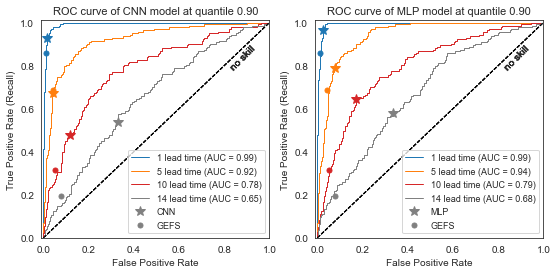

In [57]:
roc_q = 0.90
roc_m = 'CNN'
fpr, tpr, precision, recall, auc_score, f1 = roc_curve_prep(roc_q, roc_m)

lts = [0,4,9,13]

plt.rcParams['figure.figsize'] = [9, 4]

plt.subplot(1,2,1)
colors=['C0','C1','C3','gray']
for i,l in enumerate(lts):
    plt.plot(fpr['%d' %l], tpr['%d' %l], color=colors[i], 
             label='%d lead time (AUC = %0.2f)' %(l+1, auc_score['%d' %l]),
             linewidth=1)
    plt.plot(points.loc[l,'%s_%0.2f_FPR' % (roc_m, roc_q)], points.loc[l,'%s_%0.2f_TPR' % (roc_m, roc_q)],
             "*", markersize=10, color=colors[i])#, label='%s' %roc_m)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.annotate('no skill', xy=(0.82,0.78), fontsize=10, rotation=45)
    plt.plot(BM_dot[l][0],BM_dot[l][1], ".", markersize=10, color=colors[i]) #, label='GEFS')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
plt.plot(2,2, "*", markersize=10, color='gray', label='%s' %roc_m)
plt.plot(2,2, ".", markersize=10, color='gray', label='GEFS')   
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate (Recall)', fontsize=10)
plt.title('ROC curve of %s model at quantile %0.2f' % (roc_m, roc_q), fontsize=11)
plt.legend(loc="best", fontsize=9)
# plt.savefig('/final_figures/5_1.svg', format='svg', dpi=1200)
# plt.savefig('/final_figures/5_1.png')
# plt.show()

plt.subplot(1,2,2)

roc_q = 0.90
roc_m = 'MLP'
fpr, tpr, precision, recall, auc_score, f1 = roc_curve_prep(roc_q, roc_m)

lts = [0,4,9,13]

plt.rcParams['figure.figsize'] = [6, 6]

colors=['C0','C1','C3','gray']
for i,l in enumerate(lts):
    plt.plot(fpr['%d' %l], tpr['%d' %l], color=colors[i], 
             label='%d lead time (AUC = %0.2f)' %(l+1, auc_score['%d' %l]),
             linewidth=1)
    plt.plot(points.loc[l,'%s_%0.2f_FPR' % (roc_m, roc_q)], points.loc[l,'%s_%0.2f_TPR' % (roc_m, roc_q)], 
             "*", markersize=10, color=colors[i])#, label='%s' %roc_m)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.annotate('no skill', xy=(0.82,0.78), fontsize=10, rotation=45)
    plt.plot(BM_dot[l][0],BM_dot[l][1], ".", markersize=10, color=colors[i]) #, label='GEFS')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])

plt.plot(2,2, "*", markersize=10, color='gray', label='%s' %roc_m)
plt.plot(2,2, ".", markersize=10, color='gray', label='GEFS')   
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate (Recall)', fontsize=10)
plt.title('ROC curve of %s model at quantile %0.2f' % (roc_m, roc_q), fontsize=11)
plt.legend(loc="best", fontsize=9)

plt.savefig('/final_figures/5.svg', format='svg', dpi=1200)
plt.savefig('/final_figures/5.png')
plt.show()